In [26]:

# In[3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch_dct as dct


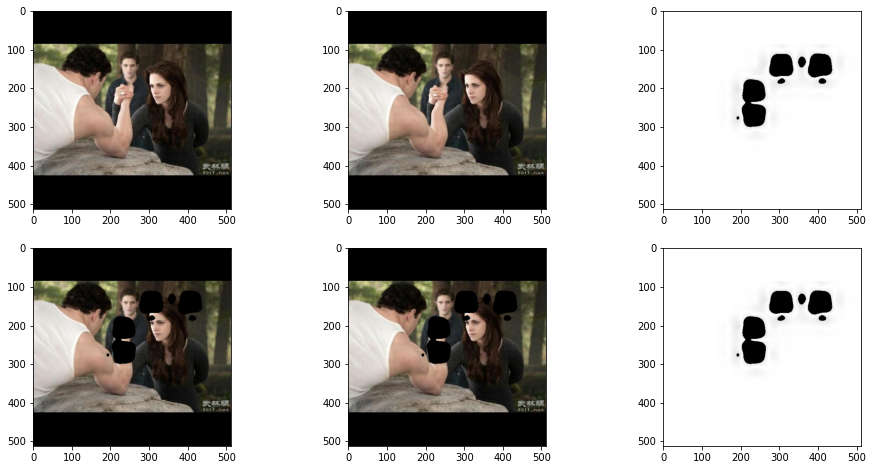

In [27]:
basic_transform = transforms.Compose(
[
        transforms.ToTensor(),
        transforms.Normalize((0., 0., 0.), (1., 1., 1.))
])
# In[3]:

target_data_dir = "/workspace/inpaint_mask/data/warpData/CIHP/Training/tps_dgrid_p16/"
sample_id = "0027253"


origin = Image.open(f"{target_data_dir}/origin/{sample_id}.jpg")
warpped = Image.open(f"{target_data_dir}/warpped/{sample_id}.jpg")
mask = np.load(f"{target_data_dir}/mask/{sample_id}.npy")
mask_tensor = torch.from_numpy(mask).permute(2,0,1).to(dtype = torch.float32)
mask_tensor[mask_tensor < 0.9] =0 
origin_tensor = basic_transform(origin)
warpped_tensor = basic_transform(warpped)


fig, axs = plt.subplots(2, 3, figsize=(16,8))
axs[0,0].imshow(origin)
axs[0,1].imshow(warpped)
axs[0,2].imshow(mask ,cmap="gray")

axs[1,0].imshow( Image.fromarray(np.uint8(np.array(origin) * mask)))
axs[1,1].imshow( Image.fromarray(np.uint8(np.array(warpped) * mask)))
# axs[1,2].imshow(np.ones_like(origin)*255)
axs[1,2].imshow(mask ,cmap="gray")


In [28]:
from torchvision.transforms.functional import to_pil_image
import lpips


class LPIPS_filter():
    def __init__(self,lpips_threshold, unmask_value = 0): #  unmask_value = 0 | 1
        self.lpips_threshold = lpips_threshold
        self.loss_fn_alex = lpips.LPIPS(net='alex')
        self.unmask_value = unmask_value
    def __call__(self,mask,origin_tensor,warpped_tensor):
        
        lpips_threshold = self.lpips_threshold
        loss_fn_alex = self.loss_fn_alex
        image_size = origin_tensor.shape[-2:]
        
        NUM_SIZE = 16
        PATCH_SIZE = k_size=image_size[0]//NUM_SIZE
        patches = mask.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
        warpped_patches = warpped_tensor.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
        origin_patches = origin_tensor.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)

        have_mask_list = []
        for i in range(NUM_SIZE):
            for j in range(NUM_SIZE):
                sub_img = patches[:, i, j]
                if(torch.count_nonzero(sub_img)!=0):
                    have_mask_list.append((i,j))
        threshold_mask_patches = patches.clone()
        
        unmask_patch = torch.zeros(patches.shape[-2:]) if self.unmask_value == 0 else torch.ones(patches.shape[-2:])

        for idx,(i,j) in enumerate(have_mask_list):
            w_patch = warpped_patches[:,i,j]
            o_patch = origin_patches[:,i,j]
            loss = loss_fn_alex(w_patch,o_patch).mean().item()
            if loss < lpips_threshold:
                threshold_mask_patches[:,i,j] = unmask_patch.clone()
                
        return threshold_mask_patches.permute(0,1,3,2,4).flatten(start_dim=3,end_dim=4).flatten(start_dim=1,end_dim=2)
        
        

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/me/.local/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


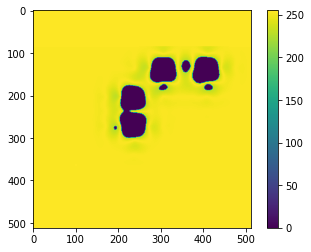

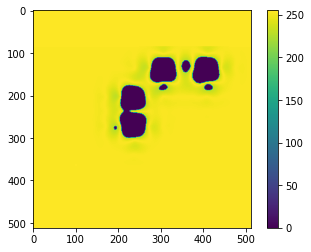

In [29]:
lpips_filter = LPIPS_filter(lpips_threshold = 0,unmask_value = 1)
new_mask = lpips_filter(mask_tensor,origin_tensor,warpped_tensor)
from torchvision.transforms.functional import to_pil_image
plt.imshow(to_pil_image(mask_tensor))
plt.colorbar()
plt.show()
plt.imshow(to_pil_image(new_mask))
plt.colorbar()

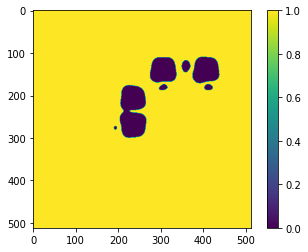

In [30]:
mask_t = mask.copy()
mask_t[mask_t < 0.1] =0
mask_t[mask_t >= 0.1] =1
plt.imshow(mask_t)
plt.colorbar()

In [31]:
def rgb_to_ycbcr(image: torch.Tensor) -> torch.Tensor:
    r"""Convert an RGB image to YCbCr.

    Args:
        image (torch.Tensor): RGB Image to be converted to YCbCr.

    Returns:
        torch.Tensor: YCbCr version of the image.
    """

    if not torch.is_tensor(image):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(image)))

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError("Input size must have a shape of (*, 3, H, W). Got {}"
                         .format(image.shape))

    r: torch.Tensor = image[..., 0, :, :]
    g: torch.Tensor = image[..., 1, :, :]
    b: torch.Tensor = image[..., 2, :, :]

    delta = .5
    y: torch.Tensor = .299 * r + .587 * g + .114 * b
    cb: torch.Tensor = (b - y) * .564 + delta
    cr: torch.Tensor = (r - y) * .713 + delta
    return torch.stack((y, cb, cr), -3)

In [45]:
import jpegio
def get_jpeg_info(im_path):
        """
        :param im_path: JPEG image path
        :return: DCT_coef (Y,Cb,Cr), qtables (Y,Cb,Cr)
        """
        num_channels = 3
        jpeg = jpegio.read(str(im_path))

        # determine which axes to up-sample
        ci = jpeg.comp_info
        need_scale = [[ci[i].v_samp_factor, ci[i].h_samp_factor] for i in range(num_channels)]
        if num_channels == 3:
            if ci[0].v_samp_factor == ci[1].v_samp_factor == ci[2].v_samp_factor:
                need_scale[0][0] = need_scale[1][0] = need_scale[2][0] = 2
            if ci[0].h_samp_factor == ci[1].h_samp_factor == ci[2].h_samp_factor:
                need_scale[0][1] = need_scale[1][1] = need_scale[2][1] = 2
        else:
            need_scale[0][0] = 2
            need_scale[0][1] = 2

        # up-sample DCT coefficients to match image size
        DCT_coef = []
        for i in range(num_channels):
            r, c = jpeg.coef_arrays[i].shape
            coef_view = jpeg.coef_arrays[i].reshape(r//8, 8, c//8, 8).transpose(0, 2, 1, 3)
            # case 1: row scale (O) and col scale (O)
            if need_scale[i][0]==1 and need_scale[i][1]==1:
                out_arr = np.zeros((r * 2, c * 2))
                out_view = out_arr.reshape(r * 2 // 8, 8, c * 2 // 8, 8).transpose(0, 2, 1, 3)
                out_view[::2, ::2, :, :] = coef_view[:, :, :, :]
                out_view[1::2, ::2, :, :] = coef_view[:, :, :, :]
                out_view[::2, 1::2, :, :] = coef_view[:, :, :, :]
                out_view[1::2, 1::2, :, :] = coef_view[:, :, :, :]

            # case 2: row scale (O) and col scale (X)
            elif need_scale[i][0]==1 and need_scale[i][1]==2:
                out_arr = np.zeros((r * 2, c))
                DCT_coef.append(out_arr)
                out_view = out_arr.reshape(r*2//8, 8, c // 8, 8).transpose(0, 2, 1, 3)
                out_view[::2, :, :, :] = coef_view[:, :, :, :]
                out_view[1::2, :, :, :] = coef_view[:, :, :, :]

            # case 3: row scale (X) and col scale (O)
            elif need_scale[i][0]==2 and need_scale[i][1]==1:
                out_arr = np.zeros((r, c * 2))
                out_view = out_arr.reshape(r // 8, 8, c * 2 // 8, 8).transpose(0, 2, 1, 3)
                out_view[:, ::2, :, :] = coef_view[:, :, :, :]
                out_view[:, 1::2, :, :] = coef_view[:, :, :, :]

            # case 4: row scale (X) and col scale (X)
            elif need_scale[i][0]==2 and need_scale[i][1]==2:
                out_arr = np.zeros((r, c))
                out_view = out_arr.reshape(r // 8, 8, c // 8, 8).transpose(0, 2, 1, 3)
                out_view[:, :, :, :] = coef_view[:, :, :, :]

            else:
                raise KeyError("Something wrong here.")

            DCT_coef.append(out_arr)

        # quantization tables
        qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]

        return DCT_coef, qtables

In [46]:
DCT_coef, qtables = get_jpeg_info(f"{target_data_dir}/warpped/{sample_id}.jpg")

<ipython-input-45-d919286d0164>:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]


In [67]:
DCT_Y_tensor = torch.from_numpy(DCT_coef[0]).unsqueeze(0).to(dtype=torch.float)

rgb_dcty = torch.cat((warpped_tensor,DCT_Y_tensor),dim=0).unsqueeze(0)
rgb_dcty.shape,DCT_Y_tensor.dtype, warpped_tensor.dtype

(torch.Size([1, 4, 512, 512]), torch.float32, torch.float32)

In [75]:
import torch_dct as dct

dct_warpped = dct.dct_2d(warpped_tensor)   # DCT-II done through the last dimension
dct_warpped.shape

torch.Size([3, 512, 512])

In [69]:
DCT_Y_tensor

tensor([[[-128.,    0.,    0.,  ...,    0.,    0.,    0.],
         [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
         [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
         ...,
         [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
         [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
         [   0.,    0.,    0.,  ...,    0.,    0.,    0.]]])

In [68]:
conv_f = torch.nn.Conv2d(4, 3, kernel_size=(1,1))
conv_f(rgb_dcty).shape

torch.Size([1, 3, 512, 512])

In [52]:
warpped_tensor.shape,DCT_Y_tensor.shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

In [39]:
torch.from_numpy(DCT_coef[0]).unsqueeze(0).shape

torch.Size([1, 512, 512])

In [7]:
from torchvision.transforms.functional import to_pil_image
import torchvision
mask_tensor =  torch.DoubleTensor((1-mask_t)[...,0])
# mask_tensor = torchvision.transforms.functional.resize(mask_tensor.unsqueeze(0),size=(64,64))[0]
patches = mask_tensor.unfold(0,8,8).unfold(1,8,8)
print(patches.shape)
N = patches.shape[0]
print(N)
# fig, ax = plt.subplots(N,N)
print(N,N)
for i in range(N):
    for j in range(N):
        sub_img = patches[i, j]
        if(torch.count_nonzero(sub_img)!=0):
            have_mask_list.append([i, j])
        non_mask_list.append([i, j])
        # ax[i][j].imshow(to_pil_image(sub_img))
        # ax[i][j].axis('off')


torch.Size([64, 64, 8, 8])
64
64 64


NameError: name 'non_mask_list' is not defined

In [8]:
unfold2_f_t.shape

NameError: name 'unfold2_f_t' is not defined

img_id: 0027253


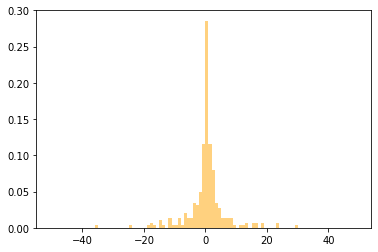

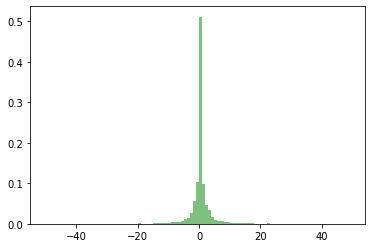

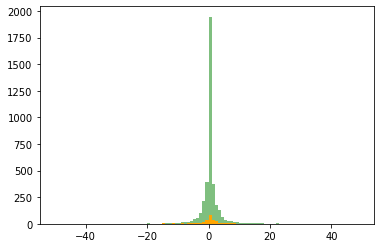

In [9]:
print("img_id:", sample_id )
f = DCT_coef[0]
f_t = torch.DoubleTensor(f)
unfold2_f_t = f_t.unfold(0,8,8).unfold(1,8,8)
mask_tensor =  torch.DoubleTensor((1-mask_t)[...,0])
patches = mask_tensor.unfold(0,8,8).unfold(1,8,8)
N = patches.shape[0]
have_mask_list = []
non_mask_list = []
for i in range(N):
    for j in range(N):
        sub_img = patches[i, j]
        if(torch.count_nonzero(sub_img)!=0):
            have_mask_list.append(unfold2_f_t[i,j,:,:])
        else:
            non_mask_list.append(unfold2_f_t[i,j,:,:])
# plt.hist(unfold2_f_t_1_1[have_mask_list],density=True,color='orange')
have_mask_DCT = torch.stack(have_mask_list)
non_mask_DCT = torch.stack(non_mask_list)
getBins = lambda x : np.arange(-50,50,step = 1)
w_dct = have_mask_DCT[:,1,1].numpy().flatten()
# w_dct = w_dct[np.abs(w_dct)>3]
o_dct = non_mask_DCT[:,1,1].numpy().flatten()
# o_dct = o_dct[np.abs(o_dct)>3]
plt.hist(w_dct,density=True,color='orange',alpha=0.5,bins=getBins(w_dct))
plt.show()
plt.hist(o_dct,density=True,color='green',alpha=0.5,bins=getBins(o_dct))
plt.show()
plt.hist(o_dct,density=False,color='green',alpha=0.5,bins=getBins(o_dct))
plt.hist(w_dct,density=False,color='orange',alpha=1,bins=getBins(w_dct))
plt.show()


In [56]:
have_mask_list.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
f = DCT_coef[0]
fm = DCT_coef[0][ mask_t[...,0] ==0]
fa = DCT_coef[0][ mask_t[...,0] !=0]
plt.hist(fm,density=True,color='orange')
plt.hist(fa,density=True,color='green')
plt.show()
plt.hist(f,density=True)
plt.show()

In [ ]:
print(sample_id )
f = DCT_coef[0]
fm = DCT_coef[0][ mask_t[...,0] ==0]
fa = DCT_coef[0][ mask_t[...,0] !=0]
getBins = lambda x : np.arange(-50,50,step = 3)
plt.hist(fm[np.abs(fm)-5 >= 0],density=True,color='orange',alpha =0.5, bins=getBins(fm[np.abs(fm)-5 > 0]))
plt.show()
plt.hist(fa[np.abs(fa)-5 >= 0],density=True,color='green',alpha =0.5, bins=getBins(fa[np.abs(fa)-10 > 0]))
plt.show()

In [ ]:
getBins(fm[np.abs(fm)-5 > 0])

In [ ]:
np.abs(fm)-100 > 0

In [ ]:
im_path = f"{target_data_dir}/warpped/{sample_id}.jpg"
jpeg = jpegio.read(str(im_path))
coef = jpeg.coef_arrays[0]

In [ ]:
coef.shape